# Naive Bayes Model with Feature Selection

This notebook trains a Gaussian Naive Bayes classifier with correlation-based feature selection.

**Key Strategy**: Since Naive Bayes assumes feature independence, we identify and remove highly correlated features to improve performance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

X_train = train_df.drop('price_range', axis=1)
y_train = train_df['price_range']
X_test = test_df.drop('price_range', axis=1)
y_test = test_df['price_range']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1600, 20)
Test set: (400, 20)


## Step 2: Correlation Analysis

Since Naive Bayes assumes feature independence, we'll identify and remove highly correlated features.

In [3]:
# Calculate correlation matrix
correlation_matrix = X_train.corr().abs()

# Find pairs of features with correlation > 0.8
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (correlation > 0.8):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

In [4]:
# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Step 3: Feature Selection

Drop one feature from each highly correlated pair to reduce multicollinearity.

In [5]:
# Identify features to drop (keep first feature from each pair, drop second)
features_to_drop = set()
for feat1, feat2, corr in high_corr_pairs:
    # Drop the second feature in each pair
    features_to_drop.add(feat2)

print(f"\nFeatures to drop: {features_to_drop}")
print(f"Original feature count: {X_train.shape[1]}")
print(f"Reduced feature count: {X_train.shape[1] - len(features_to_drop)}")

# Create reduced feature sets
X_train_reduced = X_train.drop(columns=list(features_to_drop))
X_test_reduced = X_test.drop(columns=list(features_to_drop))

print(f"\nReduced training set shape: {X_train_reduced.shape}")
print(f"Reduced test set shape: {X_test_reduced.shape}")

## Step 4: Preprocessing Pipeline

Create preprocessing pipeline for the reduced feature set.

In [6]:
# Preprocessing with reduced features
numeric_cols = X_train_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols)],
    remainder='drop'
)

## Step 5: Hyperparameter Tuning with Reduced Features

Train Naive Bayes model with the reduced feature set.

In [7]:
# Hyperparameter tuning with reduced features
# Note: GaussianNB has limited hyperparameters
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GaussianNB())
])

param_grid = {
    'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Smoothing parameter
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print("Starting hyperparameter tuning with reduced features...")
grid_search.fit(X_train_reduced, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning with reduced features...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'clf__var_smoothing': 1e-09}
Best CV score: 0.7988


## Step 6: Model Evaluation

In [8]:
# Evaluate on test set with reduced features
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8100

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       100
           1       0.71      0.69      0.70       100
           2       0.70      0.73      0.71       100
           3       0.91      0.92      0.92       100

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



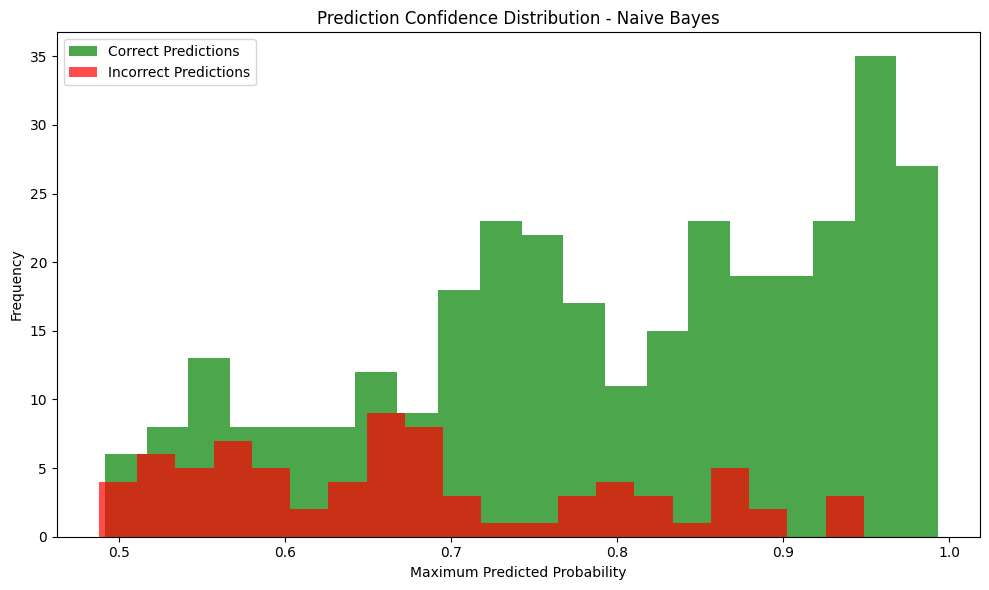


Average confidence for correct predictions: 0.7982
Average confidence for incorrect predictions: 0.6751


In [6]:
# Analyze class probabilities
y_proba = best_model.predict_proba(X_test)

# Plot probability distribution for correct vs incorrect predictions
correct_mask = y_pred == y_test
correct_proba = y_proba[correct_mask].max(axis=1)
incorrect_proba = y_proba[~correct_mask].max(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_proba, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
plt.xlabel('Maximum Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution - Naive Bayes')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAverage confidence for correct predictions: {correct_proba.mean():.4f}")
print(f"Average confidence for incorrect predictions: {incorrect_proba.mean():.4f}")

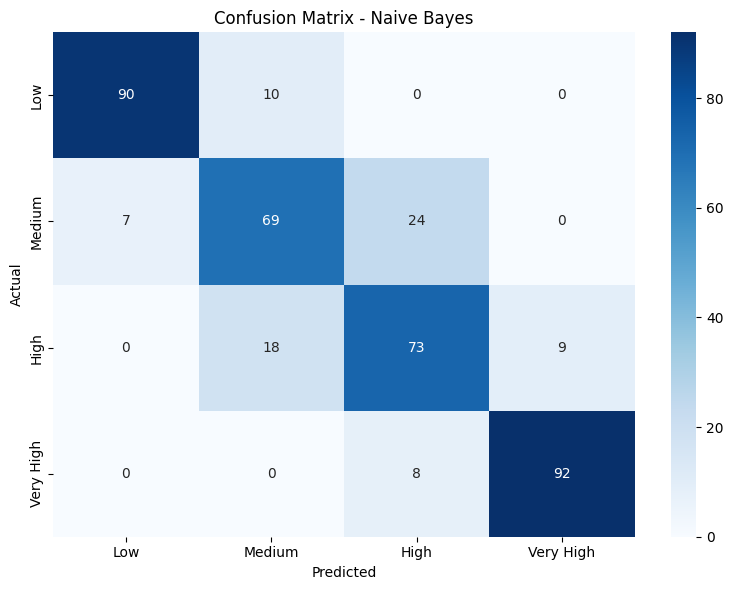

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.tight_layout()
plt.show()

In [8]:
# Feature statistics per class
# Naive Bayes learns mean and variance for each feature per class
clf = best_model.named_steps['clf']
feature_names = X_train.columns

print("\nFeature means per class (first 5 features):")
means_df = pd.DataFrame(clf.theta_, columns=feature_names, index=['Low', 'Medium', 'High', 'Very High'])
print(means_df.iloc[:, :5])


Feature means per class (first 5 features):
           battery_power      blue  clock_speed  dual_sim        fc
Low            -0.273486  0.001250     0.041517 -0.018752 -0.022484
Medium         -0.021975 -0.003750    -0.060937 -0.013751 -0.004612
High           -0.032965 -0.018751     0.009099 -0.013751  0.033438
Very High       0.328426  0.021251     0.010322  0.046254 -0.006342


In [9]:
# Save model
joblib.dump(best_model, 'saved_models/Naive_Bayes_model.joblib')
print("Model saved to saved_models/Naive_Bayes_model.joblib")

Model saved to saved_models/Naive_Bayes_model.joblib
